In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import timm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# class Patchify(nn.Module):
#     def __init__(self, patch_size):
#         super().__init__()
#         self.p = patch_size
#         self.unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)

#     def forward(self, x):
#         # x -> B c h w
#         bs, c, h, w = x.shape
        
#         x = self.unfold(x)
#         # x -> B (c*p*p) L
        
#         # Reshaping into the shape we want
#         a = x.view(bs, c, self.p, self.p, -1).permute(0, 4, 1, 2, 3)
#         # a -> ( B no.of patches c p p )
#         return a

In [3]:
# def random_mask(img, patch_size, mask_ratio):
#     """
#     Apply patch-based random masking to the input image.

#     Parameters:
#     img (torch.Tensor): Input image tensor of shape (batch_size, channels, height, width).
#     patch_size (int): Size of each patch (patch_size x patch_size).
#     mask_ratio (float): Proportion of patches to mask (0 < mask_ratio < 1).

#     Returns:
#     torch.Tensor: Masked image with only selected patches kept.
#     """
#     batch_size, channels, height, width = img.size()
#     # print("Height:", height)
#     # print("Width:", width)

#     # Ensure the image dimensions are divisible by patch_size
#     assert height % patch_size == 0 and width % patch_size == 0, \
#         "Image dimensions must be divisible by the patch size."

#     # Calculate the number of patches along each dimension
#     num_patches_h = height // patch_size
#     num_patches_w = width // patch_size
#     total_patches = num_patches_h * num_patches_w
#     num_keep = int((1 - mask_ratio) * total_patches)

#     np.random.seed(64)  # Seed for reproducibility

#     # Initialize output tensor
#     masked_img = torch.zeros_like(img)

#     # Apply patchify and masking for each image in the batch
#     patchify = Patchify(patch_size=patch_size)
#     patches = patchify(img)  # Extract patches

#     for b in range(batch_size):
#         # Randomly select patches to keep
#         keep_indices = np.random.choice(total_patches, num_keep, replace=False)

#         # Keep only selected patches
#         for idx in keep_indices:
#             patch = patches[b, idx]  # Get the patch
#             row = (idx // num_patches_w) * patch_size
#             col = (idx % num_patches_w) * patch_size

#             # Place the patch back in the corresponding location
#             masked_img[b, :, row:row + patch_size, col:col + patch_size] = patch

#     return masked_img

In [4]:
import torch

def random_jigsaw_mask(image, patch_size=32, shuffle_ratio=0.4):
    """
    Partially shuffle patches in a batch of images.
    Args:
        image (torch.Tensor): Input tensor of shape (B, C, H, W).
        patch_size (int): Size of each patch.
        shuffle_ratio (float): Fraction of patches to shuffle (0 <= shuffle_ratio <= 1).
    Returns:
        torch.Tensor: Tensor with partially shuffled patches, same shape as input.
    """
    B, C, H, W = image.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch_size"

    # Number of patches
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    total_patches = num_patches_h * num_patches_w

    # Reshape the image into patches
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()  # Shape: (B, num_patches_h, num_patches_w, C, patch_size, patch_size)
    patches = patches.view(B, -1, C, patch_size, patch_size)  # Shape: (B, num_patches, C, patch_size, patch_size)

    # Shuffle a subset of patches
    for b in range(B):
        patch_indices = torch.arange(total_patches)
        num_shuffled = int(total_patches * shuffle_ratio)
        shuffle_indices = patch_indices[torch.randperm(total_patches)[:num_shuffled]]
        shuffled_subset = shuffle_indices[torch.randperm(num_shuffled)]

        # Swap patches in the subset
        patches[b, shuffle_indices] = patches[b, shuffled_subset]

    # Reconstruct the image
    patches = patches.view(B, num_patches_h, num_patches_w, C, patch_size, patch_size)
    patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()  # Shape: (B, C, num_patches_h * patch_size, num_patches_w * patch_size)
    shuffled_image = patches.view(B, C, H, W)

    return shuffled_image

In [13]:
import os
import kagglehub

# Now the dataset will be downloaded in that directory:
path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")
print("Path to dataset files:", path)


Path to dataset files: /home/sonanhbui/.cache/kagglehub/datasets/shuvoalok/raf-db-dataset/versions/2


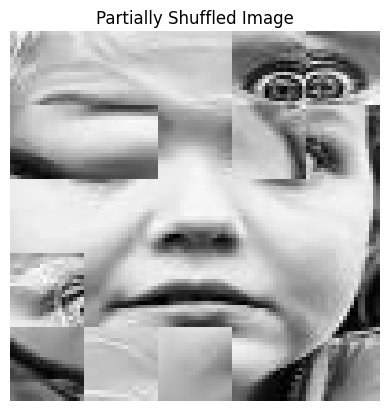

In [14]:
import cv2
# Example usage
img_src = "/home/sonanhbui/projects/mae-research/data/raf-db-dataset/DATASET/train/1/train_00006_aligned.jpg"
image = cv2.imread(img_src)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255.0
image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0)  # Shape: (1, C, H, W)

# Apply partial jigsaw mask
shuffled_image = random_jigsaw_mask(image, patch_size=20, shuffle_ratio=0.4)

# Visualize
plt.imshow(shuffled_image[0].permute(1, 2, 0).numpy())
plt.axis('off')
plt.title("Partially Shuffled Image")
plt.show()

In [15]:
# !unzip /home/sonanhbui/projects/mae-research/data/training.zip
# !unzip /home/sonanhbui/projects/mae-research/data/test.zip

Archive:  /home/sonanhbui/projects/mae-research/data/training.zip
  inflating: training.csv            
Archive:  /home/sonanhbui/projects/mae-research/data/test.zip
  inflating: test.csv                


In [17]:
target_size = 96

import pandas as pd

train_df = pd.read_csv("/home/sonanhbui/projects/mae-research/data/training.csv")
test_df = pd.read_csv("/home/sonanhbui/projects/mae-research/data/test.csv")

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Load the data
df = pd.read_csv("/home/sonanhbui/projects/mae-research/data/training.csv")

# Preprocessing the images
def preprocess_image(image_str):
    # Convert space-separated string to numpy array
    image = np.array(image_str.split(), dtype=np.float32).reshape(96, 96) / 255.0  # Normalize pixel values
    return image

df['Image'] = df['Image'].apply(preprocess_image)

# Normalize keypoints to [0, 1]
keypoint_columns = df.columns[:-1]
df[keypoint_columns] = df[keypoint_columns] / 96.0  # Assuming images are 96x96 pixels

# Handle missing values (drop rows with missing keypoints)
df = df.dropna()

# class FacialKeypointsDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         # Get the image (already a NumPy array of shape (96, 96))
#         image = self.dataframe.iloc[idx]['Image']

#         # image = np.rot90(image).copy()
#         # image = np.flipud(image).copy()
        
#         # Ensure the image has the correct shape (1, 96, 96)
#         if len(image.shape) == 2:  # If image is (96, 96), add a channel dimension
#             image = image[np.newaxis, :, :]
        
#         # Permute dimensions to match PyTorch's (C, H, W)
#         image = image.transpose(2, 1, 0)  # Correct from (96, 1, 96) to (1, 96, 96)
        
#         # Get the keypoints
#         keypoints = self.dataframe.iloc[idx][keypoint_columns].values.astype('float32')
        
#         # Apply transformations (if any)
#         if self.transform:
#             image = self.transform(image)
        
#         return torch.tensor(image, dtype=torch.float32).to(device), torch.tensor(keypoints, dtype=torch.float32).to(device)

from PIL import Image

class FacialKeypointsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # image is shape (96,96) float in [0..1], or (1,96,96)
        image = self.dataframe.iloc[idx]['Image']  # e.g. shape (96,96)

        # If shape is (1,96,96), squeeze out channel first
        if image.shape[0] == 1 and len(image.shape) == 3:
            image = image[0]  # now shape => (96,96)

        # Convert [0..1] float -> [0..255] uint8
        image_8bit = (image * 255).astype(np.uint8)  # shape => (96,96)
        
        # Turn into a PIL grayscale image
        img_pil = Image.fromarray(image_8bit, mode='L')  # 'L' => 8-bit grayscale

        # Apply TorchVision transforms if needed
        if self.transform:
            # Now transform sees a PIL Image => transforms.Resize etc. are valid
            img_pil = self.transform(img_pil)

        # Convert your keypoints
        keypoints = self.dataframe.iloc[idx][keypoint_columns].values.astype('float32')
        keypoints_torch = torch.tensor(keypoints, dtype=torch.float32)

        # Typically the pipeline ends with transforms.ToTensor(), 
        # so img_pil is now a PyTorch tensor with shape [1, H, W].
        return img_pil.to(device), keypoints_torch.to(device)



# Data transforms
# transform = transforms.Compose([
#     transforms.ToTensor(), 
# ])

transform = transforms.Compose([
    transforms.Resize((target_size, target_size)),  # Resize images to a standard size
    transforms.ToTensor(),         # Convert images to PyTorch tensors
])

from sklearn.model_selection import train_test_split

# Split the dataset
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)  # 70% train, 30% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 15% val, 15% test

# Dataset classes for train, val, and test
train_dataset = FacialKeypointsDataset(train_df, transform=transform)
val_dataset = FacialKeypointsDataset(val_df, transform=transform)
test_dataset = FacialKeypointsDataset(test_df, transform=transform)

# DataLoaders for train, val, and test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
os.chdir("/home/sonanhbui/projects/mae-research")

Epoch [1/20], Train Loss: 0.0269, Val Loss: 0.0021
Saved best model_keypoints!
Epoch [2/20], Train Loss: 0.0013, Val Loss: 0.0010
Saved best model_keypoints!
Epoch [3/20], Train Loss: 0.0010, Val Loss: 0.0009
Saved best model_keypoints!
Epoch [4/20], Train Loss: 0.0009, Val Loss: 0.0007
Saved best model_keypoints!
Epoch [5/20], Train Loss: 0.0007, Val Loss: 0.0007
Saved best model_keypoints!
Epoch [6/20], Train Loss: 0.0006, Val Loss: 0.0006
Saved best model_keypoints!
Epoch [7/20], Train Loss: 0.0005, Val Loss: 0.0005
Saved best model_keypoints!
Epoch [8/20], Train Loss: 0.0005, Val Loss: 0.0005
Saved best model_keypoints!
Epoch [9/20], Train Loss: 0.0005, Val Loss: 0.0005
Saved best model_keypoints!
Epoch [10/20], Train Loss: 0.0004, Val Loss: 0.0005
Saved best model_keypoints!
Epoch [11/20], Train Loss: 0.0004, Val Loss: 0.0004
Saved best model_keypoints!
Epoch [12/20], Train Loss: 0.0004, Val Loss: 0.0004
Saved best model_keypoints!
Epoch [13/20], Train Loss: 0.0004, Val Loss: 0.00

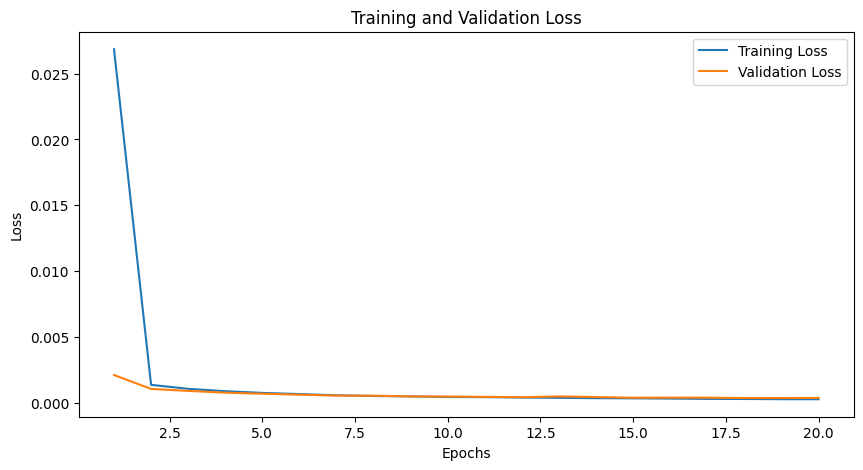

In [22]:

# Define CNN model
class KeypointCNN(nn.Module):
    def __init__(self):
        super(KeypointCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 512), nn.ReLU(),
            nn.Linear(512, len(keypoint_columns)),  # Predict all keypoint coordinates
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# Initialize model, loss, and optimizer
model_keypoints = KeypointCNN()
model_keypoints.to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.AdamW(model_keypoints.parameters(), lr=1e-4)

# Training and validation loop
epochs = 20
best_val_loss = float('inf')  # To track the best validation loss

train_losses = []
val_losses = []

for epoch in range(epochs):
    model_keypoints.train()
    train_loss = 0

    # Training phase
    for images, keypoints in train_loader:
        optimizer.zero_grad()
        outputs = model_keypoints(images.to(device))
        loss = criterion(outputs, keypoints.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model_keypoints.eval()
    val_loss = 0
    with torch.no_grad():
        for images, keypoints in val_loader:
            outputs = model_keypoints(images.to(device))
            loss = criterion(outputs, keypoints.to(device))
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Save the model_keypoints if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_keypoints.state_dict(), 'best_model_keypoints.pth')
        print("Saved best model_keypoints!")



import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("keypoints_model_train_val.png", dpi=300)
plt.show()

In [23]:
# Load the best model_keypoints
model_keypoints.load_state_dict(torch.load('/home/sonanhbui/projects/mae-research/checkpoints/best_model_keypoints.pth'))
model_keypoints.eval()

# Test phase
test_loss = 0
with torch.no_grad():
    for images, keypoints in test_loader:
        outputs = model_keypoints(images)
        loss = criterion(outputs, keypoints)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0080


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

# Load the trained model_keypoints
model_keypoints = KeypointCNN()
model_keypoints.load_state_dict(torch.load('/home/sonanhbui/projects/mae-research/checkpoints/best_model_keypoints.pth'))
model_keypoints.eval()  # Set the model_keypoints to evaluation mode

# Move the model_keypoints to GPU if available
model_keypoints.to(device)

# Function to preprocess the image
def preprocess_image(image_path):
    # Load and resize the image
    image = plt.imread(image_path)
    if len(image.shape) == 3:  # If RGB, convert to grayscale
        image = np.mean(image, axis=-1)
    image = np.resize(image, (96, 96))  # Resize to 96x96
    image = image / 255.0  # Normalize pixel values
    image = image[np.newaxis, np.newaxis, :, :]  # Add batch and channel dimensions
    return torch.tensor(image, dtype=torch.float32).to(device)

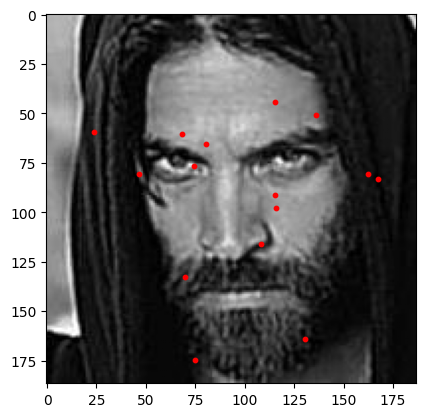

tensor([[[[0.7098, 0.7059, 0.7176,  ..., 0.1765, 0.8627, 0.7020],
          [0.6980, 0.6941, 0.7059,  ..., 0.0275, 0.4667, 0.8392],
          [0.7059, 0.7059, 0.7176,  ..., 0.0078, 0.1098, 0.7804],
          ...,
          [0.0196, 0.0392, 0.1098,  ..., 0.0431, 0.0431, 0.0431],
          [0.0157, 0.0667, 0.0980,  ..., 0.0431, 0.0431, 0.0431],
          [0.0118, 0.0627, 0.0902,  ..., 0.0431, 0.0431, 0.0431]]]],
       device='cuda:2')


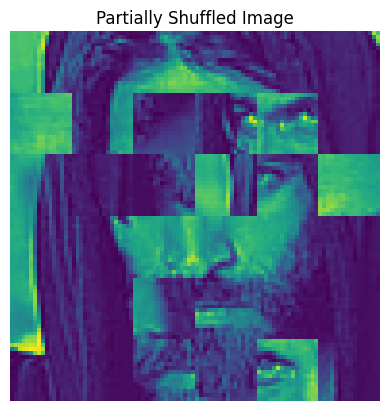

In [26]:
def preprocess_image_grayscale(image_path):
    # Load in grayscale directly
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # shape (H, W)
    # If you need to rotate/flip to match training, do so here
    # e.g. img = np.rot90(img)
    #      img = np.flipud(img)
    
    # Resize to 96x96
    img = cv2.resize(img, (96,96))
    
    # Convert to float32, scale to [0,1], shape => (1,96,96)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # now shape (1,96,96)
    
    # Turn into a batch dimension => (1,1,96,96)
    img = np.expand_dims(img, axis=0)
    return torch.tensor(img, dtype=torch.float32).to(device)

# Function to display the image with keypoints
def display_image_with_keypoints(image_path, keypoints):
    # Load the original image for display
    image = plt.imread(image_path)
    if len(image.shape) == 3:  # If RGB, convert to grayscale
        image = np.mean(image, axis=-1)
    plt.imshow(image, cmap='gray')
    
    # Denormalize keypoints (scale back to image size)
    keypoints = keypoints.cpu().detach().numpy().reshape(-1, 2)
    keypoints[:, 0] *= image.shape[1]  # Scale x-coordinates
    keypoints[:, 1] *= image.shape[0]  # Scale y-coordinates

    # Plot the keypoints
    for (x, y) in keypoints:
        plt.scatter(x, y, s=10, c='red', marker='o')
    plt.show()


def random_jigsaw_mask_keypoints(image, keypoints, patch_size=32):
    # If keypoints is 2D, add a batch dimension
    if keypoints.ndim == 2:
        keypoints = keypoints.unsqueeze(0)

    keypoints = keypoints.clamp(min=0.0, max=0.999)
        
    B, C, H, W = image.shape
    
    # --- Multiply normalized coords by width & height:
    #     (assuming your keypoints are in range [0,1])
    keypoints[:, :, 0] = keypoints[:, :, 0] * W  # x-coords
    keypoints[:, :, 1] = keypoints[:, :, 1] * H  # y-coords
    # ----------------------------------------------
    
    # The rest is unchanged...
    assert H % patch_size == 0 and W % patch_size == 0
    
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    total_patches = num_patches_h * num_patches_w

    patches = (
        image.unfold(2, patch_size, patch_size)
             .unfold(3, patch_size, patch_size)
             .permute(0, 2, 3, 1, 4, 5)
             .contiguous()
             .view(B, total_patches, C, patch_size, patch_size)
    )
    
    for b in range(B):
        patch_indices_set = set()
        # print(f"Image shape={H}x{W}, patch_size={patch_size}")
        # print(f"num_patches_h={num_patches_h}, num_patches_w={num_patches_w}, total_patches={total_patches}")
        for kp in keypoints[b]:
            x, y = kp[0].item(), kp[1].item()
            # print("Scaled x=", x, "Scaled y=", y)
            row = int(y // patch_size)
            col = int(x // patch_size)
            idx = row * num_patches_w + col
            # print(" => row=", row, "col=", col, "idx=", idx)
            patch_indices_set.add(idx)



        if patch_indices_set:
            patch_indices = torch.tensor(list(patch_indices_set), device=image.device)
            shuffled_indices = patch_indices[torch.randperm(len(patch_indices))]
            patches[b, patch_indices] = patches[b, shuffled_indices]
    
    patches = patches.view(B, num_patches_h, num_patches_w, C, patch_size, patch_size)
    patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()
    shuffled_image = patches.view(B, C, H, W)
    return shuffled_image




# Infer keypoints on a new image
image_path = '/home/sonanhbui/projects/mae-research/data/AffectNet/test/0/image0000008.jpg'  # Replace with the path to your image
input_image = preprocess_image_grayscale(image_path)
predicted_keypoints = model_keypoints(input_image).view(-1, 2)  # Predict keypoints

# Display the image with keypoints
display_image_with_keypoints(image_path, predicted_keypoints)


# import cv2
# # Example usage
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image.astype('float32') / 255.0
# image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0)  # Shape: (1, C, H, W)

# Apply partial jigsaw mask
shuffled_image = random_jigsaw_mask_keypoints(image=input_image, keypoints=predicted_keypoints, patch_size=16)
print(shuffled_image)
# Visualize
plt.imshow(shuffled_image[0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title("Partially Shuffled Image")
plt.show()

In [29]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        """
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        ####
        self.encoder = models.resnet18(pretrained=False)
        self.encoder.avgpool = nn.Identity()
        self.encoder.fc = nn.Identity()

        """

        self.encoder = timm.create_model(
            model_name="resnet18",
            pretrained=False,
        )
        self.encoder.fc = nn.Identity()
        self.encoder.global_pool = nn.Identity()

    def forward(self, x):
        x = self.encoder.forward_features(x)
        return x

Encoder()

Encoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [30]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                512, 256, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Upsample(
                scale_factor=2, mode="bilinear"),
            nn.ConvTranspose2d(
                64, 3, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(3),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [31]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Creating encoder and decoder
        self.encoder = Encoder()
        self.decoder = Decoder()


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        #print("after encoder:", z.shape)
        x_hat = self.decoder(z)
        #print("after decoder:", x_hat.shape)
        return x_hat


# Initialize the autoencoder
model = Autoencoder()
#model

In [32]:
target_size = 96

patch_size = 16
# mask_ratio = 0.4  # Define the masking ratio

batch_size = 512

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

num_epochs = 2
dataset_name = "rafdb"

In [33]:
# Define the transformation for preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((target_size, target_size)),  # Resize images to a standard size
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    # transforms.Normalize(mean=mean, std=std),  # Normalize
])

if dataset_name == "affectnet":
    train_dataset = datasets.ImageFolder(root='/home/sonanhbui/projects/mae-research/data/AffectNet/train', transform=transform)
elif dataset_name == "rafdb":
    train_dataset = datasets.ImageFolder(root='/home/sonanhbui/projects/mae-research/data/raf-db-dataset/DATASET/train', transform=transform)

# Create a DataLoader for batching
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4)

# Example: Iterate through the dataset
for images, labels in train_loader:
    print(f"Batch of images: {images.shape}")
    print(f"Batch of labels: {labels}")
    break

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/raf-db-dataset/DATASET/train'

In [ ]:

# Move the model to GPU
print(f"Using device: {device}")
# keypoints = keypoints.to(device)
# print(f"Keypoints Shape Before Processing: {keypoints.shape}")

with torch.no_grad():
    for data, labels in train_loader:
        # Assuming the dataset provides file names
        image_names = [name.split('/')[-1] for name, _ in train_loader.dataset.samples]  # Extract file names
        data = data.to(device)
        data_gray = data.mean(dim=1, keepdim=True)


        # Generate random keypoints of shape (B, K, 2) in [0,1].
        # e.g. K=5 means 5 random keypoints per image
        with torch.no_grad():
            # shape => (B, 30)
            keypoints_flat = model_keypoints(data_gray)  
            # shape => (B, 15, 2)
            num_keypoints = 15
            predicted_keypoints = keypoints_flat.view(-1, num_keypoints, 2)
        
        # Generate masked images
        # masked_img = random_mask(data.clone(), patch_size=patch_size, mask_ratio=mask_ratio)
        # masked_img = random_jigsaw_mask(data.clone(), patch_size=patch_size, shuffle_ratio=mask_ratio)
        # masked_img = shuffle_masked_regions(data.clone(), keypoints=keypoints)
        masked_img = random_jigsaw_mask_keypoints(data.clone(), keypoints=predicted_keypoints, patch_size=patch_size)
        break  # Process only the first batch for visualization

# Plot original and masked images
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 10, figsize=(15, 6))

for i in range(10):
    # Retrieve image name and class
    img_name = image_names[i]
    img_class = labels[i].item() if labels is not None else "Unknown"

    # Original images
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[0, i].set_title(f"Original\n{img_name}\nClass: {img_class}", fontsize=8)
    ax[0, i].axis('OFF')

    # --- Denormalize and plot keypoints ---
    # predicted_keypoints is shape (B, num_keypoints, 2)
    # We'll extract keypoints for the i-th image
    kps = predicted_keypoints[i].cpu().numpy()  # shape (num_keypoints, 2)
    # data[i].shape => (C, H, W)
    H_, W_ = data[i].shape[1], data[i].shape[2]
    # Scale x by width, y by height
    kps[:, 0] *= W_
    kps[:, 1] *= H_
    # Scatter them on the same axes
    ax[0, i].scatter(kps[:, 0], kps[:, 1], s=10, c='red', marker='o')

    # Masked images
    ax[1, i].imshow(masked_img[i].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[1, i].set_title(f"Masked\n{img_name}\nClass: {img_class}", fontsize=8)
    ax[1, i].axis('OFF')

# Ensure the layout is compact
plt.tight_layout()
plt.savefig("original_and_masked.png", dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_loss = float('inf')
stagnant_epochs = 0  # Counter for early stopping

# Track loss values
loss_values = []

for epoch in range(num_epochs+1):
    print(f"Running epoch {epoch}...")
    epoch_loss = 0.0
    
    for batch_idx, (imgs, _) in enumerate(tqdm(train_loader)):
        imgs = imgs.to(device)
        imgs_gray = imgs.mean(dim=1, keepdim=True)  # shape => [B,1,H,W], also on GPU
        imgs_3c = imgs.repeat(1, 3, 1, 1)  # replicate grayscale to 3 channels


        # Predict keypoints (shape => (B,30)), then reshape => (B,15,2)
        with torch.no_grad():
            keypoints_flat = model_keypoints(imgs_gray)
            num_keypoints = 15
            predicted_keypoints = keypoints_flat.view(-1, num_keypoints, 2)

        # Apply random jigsaw mask
        masked_imgs = random_jigsaw_mask_keypoints(
            imgs.clone(), 
            keypoints=predicted_keypoints, 
            patch_size=patch_size
        )

        optimizer.zero_grad()
        
        # After obtaining masked_imgs with shape [B, 1, H, W]
        masked_imgs_3c = masked_imgs.repeat(1, 3, 1, 1)  # [B, 3, H, W] # Replicate to make the image has 3 channel
        output = model(masked_imgs_3c) # Reconstruct

        loss = criterion(output, imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # ─────────────────────────────────────────────────────────
        # DISPLAY ONLY THE FIRST IMAGE OF THE FIRST BATCH (ONCE)
        # ─────────────────────────────────────────────────────────
        if epoch == 0 and batch_idx == 0:
            # 1) Convert the first original image to CPU/numpy
            original_img = imgs[0].detach().cpu().numpy().transpose(1, 2, 0)
            # 2) Convert the first masked image to CPU/numpy
            masked_img = masked_imgs[0].detach().cpu().numpy().transpose(1, 2, 0)
            # 3) Convert the first set of keypoints to CPU/numpy
            kps = predicted_keypoints[0].detach().cpu().numpy().copy()

            # The shape of original_img is (H, W, C)
            H_, W_ = original_img.shape[:2]
            # Denormalize keypoints from [0,1] to pixel coords
            kps[:, 0] *= W_
            kps[:, 1] *= H_

            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            
            # Show original
            axes[0].imshow(original_img, cmap='gray')
            axes[0].set_title("Original w/ Keypoints")
            axes[0].axis('off')
            # Scatter keypoints
            axes[0].scatter(kps[:, 0], kps[:, 1], s=20, c='red', marker='o')

            # Show masked
            axes[1].imshow(masked_img, cmap='gray')
            axes[1].set_title("Masked")
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()
        # ─────────────────────────────────────────────────────────

    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Early stopping logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        stagnant_epochs = 0
        torch.save(model.state_dict(), f'mae_resnet18_{dataset_name}_epoch{epoch}.pth')
    else:
        stagnant_epochs += 1
        if stagnant_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch}. Best loss: {best_loss:.4f}")
            break

# Save final model
# torch.save(model.state_dict(), f'mae_resnet18_{dataset_name}_final_epochs{epoch}_imgsize{target_size}_jigsaw{mask_ratio}_patchsize{patch_size}.pth')
torch.save(model.state_dict(), f'mae_resnet18_{dataset_name}_final_epochs{epoch}_imgsize{target_size}_jigsaw_keypoints_patchsize{patch_size}.pth')

In [ ]:
"""
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_loss = float('inf')
stagnant_epochs = 0  # Counter for early stopping

# Train the autoencoder with masking
current_epoch = 0

# Track loss values
loss_values = []

for epoch in range(num_epochs):
    current_epoch = epoch
    epoch_loss = 0  # Accumulate loss for the epoch
    print(f"Running epoch {epoch}...")
    for data in tqdm(train_loader):
        imgs, _ = data
        imgs = imgs.to(device)
        imgs_gray = imgs.mean(dim=1, keepdim=True)  # shape => [B,1,H,W], also on GPU

        # 1) Predict keypoints for the *entire batch*:
        #    If model_keypoint outputs shape (B, 30), we reshape to (B, 15, 2)
        with torch.no_grad():
            # shape => (B, 30)
            keypoints_flat = model_keypoints(imgs_gray)  
            # shape => (B, 15, 2)
            num_keypoints = 15
            predicted_keypoints = keypoints_flat.view(-1, num_keypoints, 2)

        # Apply random mask to the images
        # masked_img = random_jigsaw_mask(img.clone(), patch_size=patch_size, shuffle_ratio=mask_ratio)
        # masked_img = shuffle_masked_regions(data.clone(), keypoints=keypoints)
        masked_imgs = random_jigsaw_mask_keypoints(imgs.clone(), keypoints=predicted_keypoints, patch_size=patch_size)


        optimizer.zero_grad()
        # After obtaining masked_imgs with shape [B, 1, H, W]
        masked_imgs_3c = masked_imgs.repeat(1, 3, 1, 1)  # [B, 3, H, W] # Replicate to make the image has 3 channel
        output = model(masked_imgs_3c) # Pass the masked image to the autoencoder
        # print(f"masked_img shape: {masked_imgs.shape}")
        # print(f"output shape: {output.shape}")
        # print(f"img shape: {imgs.shape}")

        loss = criterion(output, imgs)  # Compare the reconstructed image with the original
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate average loss for the epoch and save it
    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Check for early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        stagnant_epochs = 0
        # Save the model
        torch.save(model.state_dict(), f'mae_resnet18_rafdb_epoch{epoch}.pth')
    else:
        stagnant_epochs += 1

    if stagnant_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch}. Best loss: {best_loss:.4f}")
        break

# Save the final model
torch.save(model.state_dict(), f'mae_resnet18_{dataset_name}_final_epochs{current_epoch}_imgsize{target_size}_jigsaw{mask_ratio}_patchsize{patch_size}_imgsize{target_size}.pth')
"""

In [ ]:
import gc
gc.collect()

torch.cuda.empty_cache()

In [ ]:
import torch
import matplotlib.pyplot as plt

# Put the model in eval mode
model.eval()

# Just get one batch for testing
data_iter = iter(train_loader)
data, labels = next(data_iter)

# If you have file paths in `train_loader.dataset.samples`:
image_names = [name.split('/')[-1] for name, _ in train_loader.dataset.samples]
 
data = data.to(device)  # shape: [B, 1, H, W] if grayscale

with torch.no_grad():
    # 1) Generate keypoints from the keypoint model
    data_gray = data.mean(dim=1, keepdim=True)  # shape => [B,1,H,W]
    keypoints_flat = model_keypoints(data_gray)  # shape => (B,30)
    num_keypoints = 15
    predicted_keypoints = keypoints_flat.view(-1, num_keypoints, 2)

    # 2) Apply random_jigsaw_mask_keypoints
    masked_img = random_jigsaw_mask_keypoints(
        data.clone(), 
        keypoints=predicted_keypoints,
        patch_size=patch_size
    )
    
    # 3) [Optionally repeat to 3 channels if your model expects 3-ch input]
    masked_img_3c = masked_img.repeat(1, 3, 1, 1)

    # 4) Reconstruct with your autoencoder
    output = model(masked_img_3c)

    
# Move tensors back to CPU for plotting
data_cpu = data.cpu().numpy()           # [B,1,H,W]
masked_cpu = masked_img.cpu().numpy()   # [B,1,H,W]
recon_cpu = output.cpu().numpy()        # [B,3,H,W]

# Plot original, masked, and reconstructed for the first 7 images
num_show = min(7, data_cpu.shape[0])
fig, ax = plt.subplots(3, num_show, figsize=(15, 6))

for i in range(num_show):
    img_name = image_names[i] if i < len(image_names) else f"Image {i}"
    img_class = labels[i].item() if labels is not None else "Unknown"

    # ───────── Original ─────────
    # shape [1,H,W] → [H,W], display in grayscale
    orig_2d = data_cpu[i, 0, :, :]
    ax[0, i].imshow(orig_2d, cmap='gray')
    ax[0, i].set_title(f"Original\n{img_name}\nClass: {img_class}", fontsize=8)
    ax[0, i].axis('off')

    # --- Denormalize and plot keypoints ---
    # predicted_keypoints is shape (B, num_keypoints, 2)
    # We'll extract keypoints for the i-th image
    kps = predicted_keypoints[i].cpu().numpy()  # shape (num_keypoints, 2)
    # data[i].shape => (C, H, W)
    H_, W_ = data[i].shape[1], data[i].shape[2]
    # Scale x by width, y by height
    kps[:, 0] *= W_
    kps[:, 1] *= H_
    # Scatter them on the same axes
    ax[0, i].scatter(kps[:, 0], kps[:, 1], s=10, c='red', marker='o')
    

    # ───────── Masked ─────────
    masked_2d = masked_cpu[i, 0, :, :]
    ax[1, i].imshow(masked_2d, cmap='gray')
    ax[1, i].set_title(f"Masked\n{img_name}", fontsize=8)
    ax[1, i].axis('off')

    # ───────── Reconstructed ─────────
    # shape [3,H,W] → [H,W,3] for plotting
    recon_3d = recon_cpu[i].transpose(1, 2, 0)
    ax[2, i].imshow(recon_3d)
    ax[2, i].set_title(f"Reconstructed\n{img_name}", fontsize=8)
    ax[2, i].axis('off')

plt.tight_layout()
plt.savefig("original_masked_reconstructed.png", dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Suppose 'loss_values' is a list of average losses per epoch
num_epochs_ran = len(loss_values)  # How many epochs actually ran

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_ran + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)

# Save the plot to a file (PNG, 300 DPI)
plt.savefig("training_loss_plot.png", dpi=300)

# If you're in an environment that can display figures (like a notebook)
plt.show()
